# New Diffusion try

## Imports

In [20]:
import os
import copy
import math
import torch
import wandb
import shutil
import random
import logging
import zipfile
import argparse
import torchvision
import numpy as np
from tqdm import tqdm
import torch.nn as nn
from PIL import Image
from torch import einsum
from pathlib import Path
import torch.optim as optim
from torch.optim import Adam
import torch.nn.functional as F
import matplotlib.pyplot as plt
from types import SimpleNamespace
import torchvision.transforms as T
from contextlib import nullcontext
from fastprogress import progress_bar
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Dataset

In [21]:
class RadarDataset(Dataset):
    def __init__(self, num_samples, n_targets, random_n_targets, nu=None, scnr=None, snr=None, cnr=None):
        super().__init__()
        self.num_samples = num_samples
        self.n_targets = n_targets
        self.random_n_targets = random_n_targets
        self.with_targets = n_targets > 0
        self.snr_dB = snr
        self.cnr_dB = cnr
        self.scnr = scnr
        self.nu = torch.tensor([nu], dtype=torch.float) if nu is not None else None

        # Radar parameters
        self.N = 64       # fast–time samples per pulse
        self.K = 64       # slow–time pulses per frame
        self.B = 50e6     # Chirp bandwidth (Hz)
        self.T0 = 1e-3    # PRI (s)
        self.fc = 9.39e9  # Carrier frequency (Hz)
        self.c = 3e8      # Speed of light (m/s)
        self.CNR = 15     # in dB (only used if snr/cnr are NOT given)

        # Range and Doppler settings
        self.r_min, self.r_max = 0, 189    # meters
        self.v_min, self.v_max = -7.8, 7.8   # m/s (for targets)
        self.vc_min, self.vc_max = -7.8, 7.8 # m/s (for clutter)
        self.dr = 3       # Range resolution in m
        self.dv = 0.249   # Doppler resolution in m/s

        # Range and Doppler bins (for label maps)
        self.R = torch.arange(self.r_min, self.r_max + self.dr, self.dr)
        self.V = torch.arange(self.v_min, self.v_max + self.dv, self.dv)
        self.dR = len(self.R)
        self.dV = len(self.V)

        # Noise power calculation (only used if snr/cnr not specified)
        self.sigma2 = self.N / (2 * 10 ** (self.CNR / 10))
        
        # For old scnr logic, we also computed a "normalization" factor
        self.cn_norm = torch.sqrt(
            torch.tensor(
                self.N * self.K * (self.N // 2 + self.sigma2), dtype=torch.float
            )
        )

    def generate_target_signal(self, ranges, velocities, phases, gains_dB):
        """
        Creates the raw (unscaled) target signals for each target,
        then (if old scnr approach) scales them to achieve the desired scnr in dB,
        or returns them raw for later scaling if snr/cnr approach is used.
        """
        # Range steering vector (one per target)
        w_r = (2 * torch.pi * 2 * self.B * ranges) / (self.c * self.N)
        range_steering = torch.exp(-1j * torch.outer(w_r, torch.arange(self.N, dtype=torch.float)))
        
        # Doppler steering vector (one per target)
        w_d = (2 * torch.pi * self.T0 * 2 * self.fc * velocities) / self.c
        doppler_steering = torch.exp(-1j * torch.outer(w_d, torch.arange(self.K, dtype=torch.float)))
        
        # Form the fast–time × slow–time target signature for each target
        rd_signal = range_steering.unsqueeze(-1) * doppler_steering.unsqueeze(1)
        rd_signal = rd_signal * torch.exp(1j * phases)  # impart random phase per target
        
        # If we are using the old SCNR approach, scale immediately
        # Gains in dB => each target’s SCNR
        if (self.snr_dB is None) or (self.cnr_dB is None):
            # Old approach: sum all scaled targets into a single matrix
            S_norm = torch.linalg.norm(rd_signal, dim=(1, 2)).real
            sig_amp = (10 ** (gains_dB / 20)) * (self.cn_norm / S_norm)
            rd_signal = (sig_amp.unsqueeze(-1).unsqueeze(-1) * rd_signal).sum(dim=0)
            return rd_signal
        else:
            # With the new approach, we do NOT scale by SCNR here.
            # We return the raw sum across all targets, for later power-based scaling.
            rd_signal = rd_signal.sum(dim=0)
            return rd_signal

    def generate_clutter(self, nu):
        # Choose a clutter velocity uniformly within the allowed limits
        clutter_vel = torch.empty(1).uniform_(self.vc_min, self.vc_max)
        fd = 2 * torch.pi * (2 * self.fc * clutter_vel) / self.c 
        sigma_f = 0.05  # Correlation parameter (from the referenced paper)

        p, q = torch.meshgrid(
            torch.arange(self.N, dtype=torch.float),
            torch.arange(self.K, dtype=torch.float),
            indexing='ij'
        )
        # M is the covariance-like matrix for correlated clutter
        M = torch.exp(
            -2 * torch.pi**2 * sigma_f**2 * (p - q)**2
            - 1j * (p - q) * fd * self.T0
        )

        # Draw complex Gaussian
        z = torch.randn(self.K, self.dR, dtype=torch.cfloat) / torch.sqrt(torch.tensor(2.0))
        e, V_mat = torch.linalg.eigh(M)  # eigen-decomposition
        e_sqrt = torch.sqrt(torch.clamp(e.real, min=0.0))
        E = torch.diag(e_sqrt)
        A = V_mat @ E.to(V_mat.dtype)
        w_t = A @ z  # shaping the random draws to match M

        # Impart heavy–tailed behavior via Gamma modulation (shape = scale = nu)
        s = torch.distributions.Gamma(nu, nu).sample((self.dR,))
        c_t = (torch.sqrt(s).unsqueeze(0) * w_t.unsqueeze(-1)).squeeze(-1)

        # Convert to fast–time × slow–time representation
        # using a range–steering operation.
        c_r_steer = torch.exp(
            -1j 
            * 2 
            * torch.pi 
            * torch.outer(torch.arange(self.N, dtype=torch.float), self.R)
            * (2 * self.B) / (self.c * self.N)
        )
        C = c_r_steer @ c_t.transpose(0, 1)
        return C

    def gen_frame_and_labels(self):
        """
        Generate one radar data frame, label map, and the separate S, C, W
        so that we can control SNR and CNR (if specified).
        """
        # 1. Generate unscaled noise (mean 0, unit variance in each real/imag component).
        #    We'll measure it and scale later if snr/cnr is used.
        W_unscaled = torch.randn(self.N, self.K, dtype=torch.cfloat) / torch.sqrt(torch.tensor(2.0))
        
        # 2. Generate unscaled clutter
        nu = torch.empty(1).uniform_(0.1, 1.5) if self.nu is None else self.nu
        C_unscaled = self.generate_clutter(nu)
        
        # 3. Prepare to generate target signal(s)
        #    We'll choose random targets if with_targets == True
        S_unscaled = torch.zeros(self.N, self.K, dtype=torch.cfloat)
        rd_label = torch.zeros(self.dR, self.dV)

        if self.with_targets:
            n = (
                torch.randint(1, self.n_targets + 1, (1,)).item()
                if self.random_n_targets
                else self.n_targets
            )
            ranges = torch.empty(n).uniform_(self.r_min, self.r_max)
            velocities = torch.empty(n).uniform_(self.v_min, self.v_max)
            phases = torch.empty(n, 1, 1).uniform_(0, 2 * torch.pi)
            
            # If new SNR/CNR approach is NOT used, we fallback to scnr or [-5, 10] dB random
            if (self.snr_dB is None) or (self.cnr_dB is None):
                SCNR_dBs = torch.empty(n).uniform_(-5, 10) if self.scnr is None else self.scnr * torch.ones(n)
                S_unscaled = self.generate_target_signal(ranges, velocities, phases, SCNR_dBs)
            else:
                # Just pass dummy dB array here; we won't scale inside 'generate_target_signal'
                # Instead, we will do the scaling outside
                S_raw = []
                for i in range(n):
                    # Each target can have the same 'gain' placeholder
                    s_i = self.generate_target_signal(
                        ranges[i].unsqueeze(-1),
                        velocities[i].unsqueeze(-1),
                        phases[i].unsqueeze(-1),
                        gains_dB=torch.tensor([0.0])  # placeholder
                    )
                    S_raw.append(s_i)
                # Sum all targets
                S_unscaled = sum(S_raw)

            # For each target, mark the closest range and Doppler bin.
            for r, v in zip(ranges, velocities):
                r_bin = torch.argmin(torch.abs(self.R - r))
                v_bin = torch.argmin(torch.abs(self.V - v))
                rd_label[r_bin, v_bin] = 1

        # ---------------------------
        # NEW: If snr & cnr are given, do amplitude scaling here
        # ---------------------------
        if (self.snr_dB is not None) and (self.cnr_dB is not None):
            # 1) measure raw powers
            noise_power  = W_unscaled.abs().pow(2).mean()
            clutter_power= C_unscaled.abs().pow(2).mean() if C_unscaled.numel() > 0 else 0.0
            signal_power = S_unscaled.abs().pow(2).mean() if S_unscaled.numel() > 0 else 0.0

            # 2) define desired linear ratios
            snr_lin = 10 ** (self.snr_dB / 10)
            cnr_lin = 10 ** (self.cnr_dB / 10)

            # 3) define desired final powers
            #    We'll anchor the noise to "1.0" average power for convenience
            #    (or you could anchor it to some other power). Then scale clutter & signal.
            #    Step (A): Scale noise to final_noise_power = 1.0
            #             => alpha_n = sqrt(1 / noise_power).
            alpha_n = torch.sqrt(1.0 / noise_power)
            W = alpha_n * W_unscaled  # final noise
            final_noise_power = W.abs().pow(2).mean()

            #    Step (B): Clutter should have average power = cnr_lin * final_noise_power
            if clutter_power > 0:
                alpha_c = torch.sqrt((cnr_lin * final_noise_power) / clutter_power)
                C = alpha_c * C_unscaled
            else:
                C = torch.zeros_like(C_unscaled)

            #    Step (C): Signal should have average power = snr_lin * final_noise_power
            if signal_power > 0:
                alpha_s = torch.sqrt((snr_lin * final_noise_power) / signal_power)
                S = alpha_s * S_unscaled
            else:
                S = torch.zeros_like(S_unscaled)

        else:
            W = (W_unscaled / torch.sqrt(torch.tensor(self.sigma2)))  # old approach
            C = C_unscaled
            S = S_unscaled

        X = S + C + W
        
        signal_energy  = S.abs().pow(2).sum()
        clutter_energy = C.abs().pow(2).sum()
        noise_energy   = W.abs().pow(2).sum()
        scnr_lin = signal_energy / (clutter_energy + noise_energy + 1e-12)
        scnr_dB  = 10.0 * torch.log10(scnr_lin + 1e-12)

        return S, C, W, X, rd_label, scnr_dB

    def __len__(self) -> int:
        return self.num_samples

    def __getitem__(self, idx: int):
        """
        Return the data and label for sample 'idx'.
        """
        signal, clutter, gaus_noise, IQ, rd_label, scnr_dB = self.gen_frame_and_labels()
        return signal, clutter, gaus_noise, IQ, rd_label, scnr_dB

## Helper functions

In [22]:
def set_seed(s, reproducible=False):
    "set random seed for torch, numpy and random"
    try: torch.manual_seed(s)
    except NameError: pass
    try: torch.cuda.manual_seed_all(s)
    except NameError: pass
    try: np.random.seed(s%(2**32-1)) #numpy demands seed between 0 and 2**32-1
    except NameError: pass
    random.seed(s)
    if reproducible:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False


In [23]:
def get_data(args):
    dataset_with_targets = RadarDataset(num_samples=args.num_samples, n_targets=args.n_targets, random_n_targets=True, snr=args.snr, cnr=args.cnr)
    dataset_without = RadarDataset(num_samples=args.num_samples, n_targets=args.n_targets, random_n_targets=True, snr=args.snr, cnr=args.cnr)
    full_dataset = ConcatDataset([dataset_with_targets, dataset_without])
    train_size = int(0.9*len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
    train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=args.num_workers, pin_memory=torch.cuda.is_available(), persistent_workers=True)
    val_loader = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=False)
    return train_loader, val_loader

In [24]:
def make_folders(run_name):
    "create folders for models and results, and subfolders for each run"
    os.makedirs("Models", exist_ok=True)
    os.makedirs("Results", exist_ok=True)
    os.makedirs(os.path.join("Models", run_name), exist_ok=True)
    os.makedirs(os.path.join("Results", run_name), exist_ok=True)


## Modules

In [25]:
def one_param(m):
    "get model first parameter"
    return next(iter(m.parameters()))

In [26]:
class EMA:
    "Exponential Moving Average, used to make training more stable"
    def __init__(self, beta):
        super().__init__()
        self.beta = beta
        self.step = 0

    def update_model_average(self, ma_model, current_model):
        for current_params, ma_params in zip(current_model.parameters(), ma_model.parameters()):
            old_weight, up_weight = ma_params.data, current_params.data
            ma_params.data = self.update_average(old_weight, up_weight)
    
    def update_average(self, old, new):
        if old is None:
            return new
        return old * self.beta + (1 - self.beta) * new
    
    def step_ema(self, ema_model, model, step_start_ema=2000):
        if self.step < step_start_ema:
            self.reset_parameters(ema_model, model)
            self.step += 1
            return
        self.update_model_average(ema_model, model)
        self.step += 1
    
    def reset_parameters(self, ema_model, model):
        ema_model.load_state_dict(model.state_dict())

In [27]:
class SelfAttention(nn.Module):
    def __init__(self, channels):
        super(SelfAttention, self).__init__()
        self.channels = channels
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True) # 4 attention heads, input tensors shape (batch, seq_len, emb_dim)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels)
        )
    def forward(self, x):
        size = x.shape[-1]
        x = x.view(-1, self.channels, size * size).swapaxes(1, 2) # (batch, channels, H, W) -> (batch, channels, H*W) -> (batch, H*W, channels) which is required for MHD
        x_ln = self.ln(x) # normalized input
        attention_value, _ = self.mha(x_ln, x_ln, x_ln) # compute self-attention where x_ln is query, key and value
        attention_value = attention_value + x # residual connection
        attention_value = self.ff_self(attention_value) + attention_value # feed forward network and residual connection again
        return attention_value.swapaxes(2, 1).view(-1, self.channels, size, size) # reshape back to (batch, channels, H, W)

In [28]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super().__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels)
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.double_conv(x))
        else:
            return self.double_conv(x)
        

In [29]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super().__init__()
        self.residual = residual
        if mid_channels is None:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels)
        )
        # If using residual and channels don't match, add a projection
        if self.residual and in_channels != out_channels:
            self.res_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)

    def forward(self, x):
        out = self.double_conv(x)
        if self.residual:
            # Project x if necessary
            if hasattr(self, 'res_conv'):
                x = self.res_conv(x)
            return F.gelu(x + out)
        else:
            return out


In [30]:
class Down(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels)
        )
        self.emb_layer = nn.Sequential(
            nn.SiLU(), 
            nn.Linear(emb_dim, out_channels)
        )
    def forward(self, x, t):
        x = self.maxpool_conv(x)
        emb = self.emb_layer(t)[:,:, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x+emb

In [31]:
class Up(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv = nn.Sequential(
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels, in_channels//2)
        )
        self.emb_layer = nn.Sequential(
            nn.SiLU(), 
            nn.Linear(emb_dim, out_channels)
        )
    def forward(self, x, skip_x, t):
        x = self.up(x)
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv(x)
        emb = self.emb_layer(t)[:,:,None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x+emb


In [32]:
class UNet(nn.Module):
    def __init__(self, c_in=4, c_out=2, time_dim=256, remove_deep_conv=False):
        super().__init__()
        self.time_dim = time_dim
        self.remove_deep_conv = remove_deep_conv
        self.inc = DoubleConv(c_in, 64)
        self.down1 = Down(64, 128)
        self.sa1 = SelfAttention(128)
        self.down2 = Down(128, 256)
        self.sa2 = SelfAttention(256)
        self.down3 = Down(256, 256)
        self.sa3 = SelfAttention(256)
        if remove_deep_conv:
            self.bot1 = DoubleConv(256, 256)
            self.bot3 = DoubleConv(256, 256)
        else:
            self.bot1 = DoubleConv(256, 512)
            self.bot2 = DoubleConv(512, 512)
            self.bot3 = DoubleConv(512, 256)
        
        self.up1 = Up(512, 128)
        self.sa4 = SelfAttention(128)
        self.up2 = Up(256, 64)
        self.sa5 = SelfAttention(64)
        self.up3 = Up(128,64)
        self.sa6 = SelfAttention(64)
        self.outc = DoubleConv(64, c_out)

    def pos_encoding(self, t, channels):
        inv_freq = 1.0 / (10000 ** (torch.arange(0, channels, 2, device=one_param(self).device).float()/channels))
        pos_enc_a = torch.sin(t.repeat(1, channels //2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels //2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc
    
    def unet_forward(self, x, t):
        x1 = self.inc(x)
        x2 = self.down1(x1, t)
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        x4 = self.sa3(x4)


        x4 = self.bot1(x4)
        if not self.remove_deep_conv:
            x4 = self.bot2(x4)
        x4 = self.bot3(x4)


        x = self.up1(x4, x3, t)
        x = self.sa4(x)
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        x = self.up3(x, x1, t)
        x = self.sa6(x)
        output = self.outc(x)
        return output

    def forward(self, x, t):
        t = t.unsqueeze(-1)
        t = self.pos_encoding(t, self.time_dim)
        return self.unet_forward(x, t)


In [33]:
class Conditional_UNet(UNet):
    def __init__(self, c_in=4, c_out=2, time_dim=256, **kwargs):
        super().__init__(c_in, c_out, time_dim, **kwargs)
        
    def forward(self, x, cond_img, t):
        t = t.unsqueeze(-1) if t.dim() == 1 else t
        t = self.pos_encoding(t, self.time_dim)  # e.g., sinusoidal or learned pos enc
        x_input = torch.cat([x, cond_img], dim=1)

        return self.unet_forward(x_input, t)


## Main

In [34]:
config = SimpleNamespace(
    run_name = "Conditional_Radar_Diffusion_v1",
    epochs = 100,
    noise_steps =1000,
    seed = 42,
    batch_size = 10,
    img_size = 64,
    device = "cuda",
    slice_size = 1,
    do_validation = True,
    fp16 = True,
    log_every_epoch = 10,
    num_workers=10,
    lr = 5e-3)

## Imports

In [ ]:
class ConditionalDiffusion(nn.Module):
    def __init__(self, model, T=1000, beta_start=1e-4, beta_end=0.02):
        super().__init__()
        self.model = model  # instance of ConditionalUNet
        self.T = T
        self.register_buffer("betas", torch.linspace(beta_start, beta_end, T))
        self.register_buffer("alphas", 1.0 - self.betas)
        self.register_buffer("alpha_bars", torch.cumprod(self.alphas, dim=0))

    def q_sample(self, x0, t, noise=None):
        """
        Forward diffusion: add noise to x0 at timestep t.
        """
        if noise is None:
            noise = torch.randn_like(x0)
        sqrt_alpha_bar = self.alpha_bars[t].sqrt().view(-1, 1, 1, 1)
        sqrt_one_minus_alpha_bar = (1 - self.alpha_bars[t]).sqrt().view(-1, 1, 1, 1)
        return sqrt_alpha_bar * x0 + sqrt_one_minus_alpha_bar * noise, noise

    def p_losses(self, x0, t, cond):
        """
        Loss: train network to predict the noise added.
        x0: clean signal (B,2,H,W) with channels [real, imag]
        cond: conditioning (observed noisy IQ) (B,2,H,W) with channels [real, imag]
        """

        x_noisy, noise = self.q_sample(x0, t)
        t_norm = t.float() / self.T
        
        # Concatenate along channel dimension: [x_noisy, cond] -> (B,4,H,W)
        #model_input = torch.cat([x_noisy, cond], dim=1)
        #noise_pred = self.model(model_input, t_norm)
        noise_pred = self.model(x_noisy, cond, t_norm)
        return F.mse_loss(noise_pred, noise)

    @torch.no_grad()
    def p_sample(self, x, t, cond):
        """
        One reverse diffusion step (from x_t to x_{t-1}).
        """
        betas_t = self.betas[t].view(-1, 1, 1, 1)
        alphas_t = self.alphas[t].view(-1, 1, 1, 1)
        alpha_bars_t = self.alpha_bars[t].view(-1, 1, 1, 1)
        t_norm = (torch.tensor([t], device=x.device).float() / self.T).repeat(x.shape[0])

        # model_input = torch.cat([x, cond], dim=1)
        # noise_pred = self.model(model_input, t_norm)
        noise_pred = self.model(x, cond, t_norm)

        coef1 = 1 / torch.sqrt(alphas_t)
        coef2 = betas_t / torch.sqrt(1 - alpha_bars_t)
        mean = coef1 * (x - coef2 * noise_pred)
        
        noise = torch.randn_like(x) if t > 0 else 0
        return mean + torch.sqrt(betas_t) * noise

    @torch.no_grad()
    def sample(self, cond, shape):
        """
        Generate a denoised signal conditioned on cond.
        cond: (B,2,H,W) the observed noisy IQ (real and imaginary)
        shape: desired shape of x (B,2,H,W)
        """
        x = torch.randn(shape, device=cond.device)
        for t in reversed(range(self.T)):
            t_tensor = torch.tensor([t], device=x.device)
            x = self.p_sample(x, t_tensor, cond)
        return x
    
def train_one_epoch(diffusion, dataloader, optimizer, device):
    diffusion.train()
    epoch_loss = 0
    for i, batch in enumerate(dataloader):
        # Unpack the tuple from the dataset.
        signal, clutter, gaus_noise, IQ, rd_label, scnr_dB = batch

        if signal.real.ndim == 3:
            x0_real = signal.real.unsqueeze(1)
            x0_imag = signal.imag.unsqueeze(1)
            cond_real = IQ.real.unsqueeze(1)
            cond_imag = IQ.imag.unsqueeze(1)
        else:
            x0_real = signal.real
            x0_imag = signal.imag
            cond_real = IQ.real
            cond_imag = IQ.imag

        # Concatenate to form 2-channel tensors.
        x0 = torch.cat([x0_real, x0_imag], dim=1).to(device)   # (B,2,H,W)
        cond = torch.cat([cond_real, cond_imag], dim=1).to(device)  # (B,2,H,W)

        # Sample random timesteps for diffusion.
        t = torch.randint(0, diffusion.T, (x0.shape[0],), device=device).long()
        
        # Compute loss.
        loss = diffusion.p_losses(x0, t, cond)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        
    return epoch_loss / len(dataloader)


@torch.no_grad()
def validate(diffusion, dataloader, device):
    diffusion.eval()
    val_loss = 0
    gen_mse, gen_psnr = None, None

    for i, batch in enumerate(dataloader):
        signal, clutter, gaus_noise, IQ, rd_label, scnr_dB = batch
        
        if signal.real.ndim == 3:
            x0_real = signal.real.unsqueeze(1)
            x0_imag = signal.imag.unsqueeze(1)
            cond_real = IQ.real.unsqueeze(1)
            cond_imag = IQ.imag.unsqueeze(1)
        else:
            x0_real = signal.real
            x0_imag = signal.imag
            cond_real = IQ.real
            cond_imag = IQ.imag

        x0 = torch.cat([x0_real, x0_imag], dim=1).to(device)  # (B,2,H,W)
        cond = torch.cat([cond_real, cond_imag], dim=1).to(device)  # (B,2,H,W)
        
        t = torch.randint(0, diffusion.T, (x0.shape[0],), device=device).long()
        loss = diffusion.p_losses(x0, t, cond)
        val_loss += loss.item()

        # For the first batch, generate a sample and compute metrics.
        if i == 0:
            generated = diffusion.sample(cond, x0.shape)
            mse_val = F.mse_loss(generated, x0).item()
            psnr_val = 20 * math.log10(x0.max().item() / math.sqrt(mse_val)) if mse_val > 0 else 100
            gen_mse, gen_psnr = mse_val, psnr_val

    avg_val_loss = val_loss / len(dataloader)
    return avg_val_loss, gen_mse, gen_psnr

full_dataset = RadarDataset(num_samples=10240, n_targets=8, random_n_targets=True, snr=30, cnr=15)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False)

train_dataset_with_targets = RadarDataset(num_samples=10240, n_targets=8, random_n_targets=True, snr=30, cnr=15)
train_dataset_no_targets = RadarDataset(num_samples=1024, n_targets=0, random_n_targets=False, snr=30, cnr=15)
train_dataset = ConcatDataset([train_dataset_with_targets, train_dataset_no_targets])
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2,
                          pin_memory=torch.cuda.is_available(), persistent_workers=True)

cond_unet = Conditional_UNet().to(device)
cond_diffusion = ConditionalDiffusion(model=cond_unet, T=1000, beta_start=1e-4, beta_end=0.02).to(device)
# unet_model = Unet(dim=64, channels=4, out_dim=2, with_time_emb=True).to(device)

# cond_diffusion = ConditionalDiffusion(
#     model=unet_model,
#     T=1000,
#     beta_start=1e-4,
#     beta_end=0.02
# ).to(device)
optimizer = torch.optim.Adam(cond_diffusion.parameters(), lr=1e-5)
num_epochs = 220
best_val_loss = float('inf')

train_losses = []
val_losses = []
val_psnrs = []
val_mses = []

for epoch in range(num_epochs):
    train_loss = train_one_epoch(cond_diffusion, train_loader, optimizer, device)
    val_loss, gen_mse, gen_psnr = validate(cond_diffusion, val_loader, device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    if gen_psnr is not None:
        val_psnrs.append(gen_psnr)
    if gen_mse is not None:
        val_mses.append(gen_mse)

    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss = {train_loss:.4f} | Val Loss = {val_loss:.4f}")
    if gen_mse is not None and gen_psnr is not None:
        print(f"   [Generation Metrics] MSE: {gen_mse:.4f} | PSNR: {gen_psnr:.2f} dB")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(cond_diffusion.state_dict(), "new_diffusion.pth")
        print("   --> Best model saved.")

# 5. Plot training curves
plt.figure(figsize=(8,6))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss")
plt.show()

if len(val_psnrs) > 0:
    plt.figure(figsize=(8,6))
    plt.plot(val_psnrs, label="Val PSNR (dB)")
    plt.xlabel("Epochs")
    plt.ylabel("PSNR")
    plt.title("Validation PSNR over epochs")
    plt.legend()
    plt.show()


Epoch 1/220: Train Loss = 1.7419 | Val Loss = 1.6882
   [Generation Metrics] MSE: 26758.4766 | PSNR: -6.31 dB
   --> Best model saved.
Epoch 2/220: Train Loss = 1.5813 | Val Loss = 1.6178
   [Generation Metrics] MSE: 19644.9375 | PSNR: -4.65 dB
   --> Best model saved.
Epoch 3/220: Train Loss = 1.4999 | Val Loss = 1.5671
   [Generation Metrics] MSE: 16599.8926 | PSNR: -4.51 dB
   --> Best model saved.
Epoch 4/220: Train Loss = 1.4452 | Val Loss = 1.5062
   [Generation Metrics] MSE: 15019.9951 | PSNR: -4.07 dB
   --> Best model saved.
Epoch 5/220: Train Loss = 1.3938 | Val Loss = 1.4157
   [Generation Metrics] MSE: 13773.3047 | PSNR: -3.06 dB
   --> Best model saved.


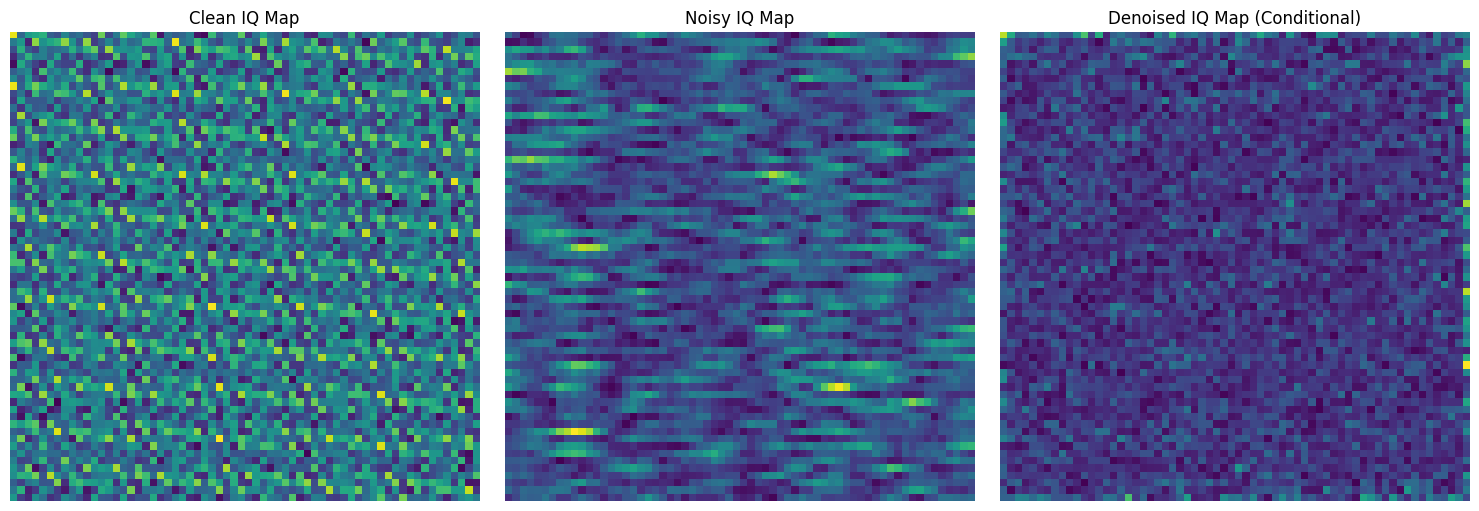

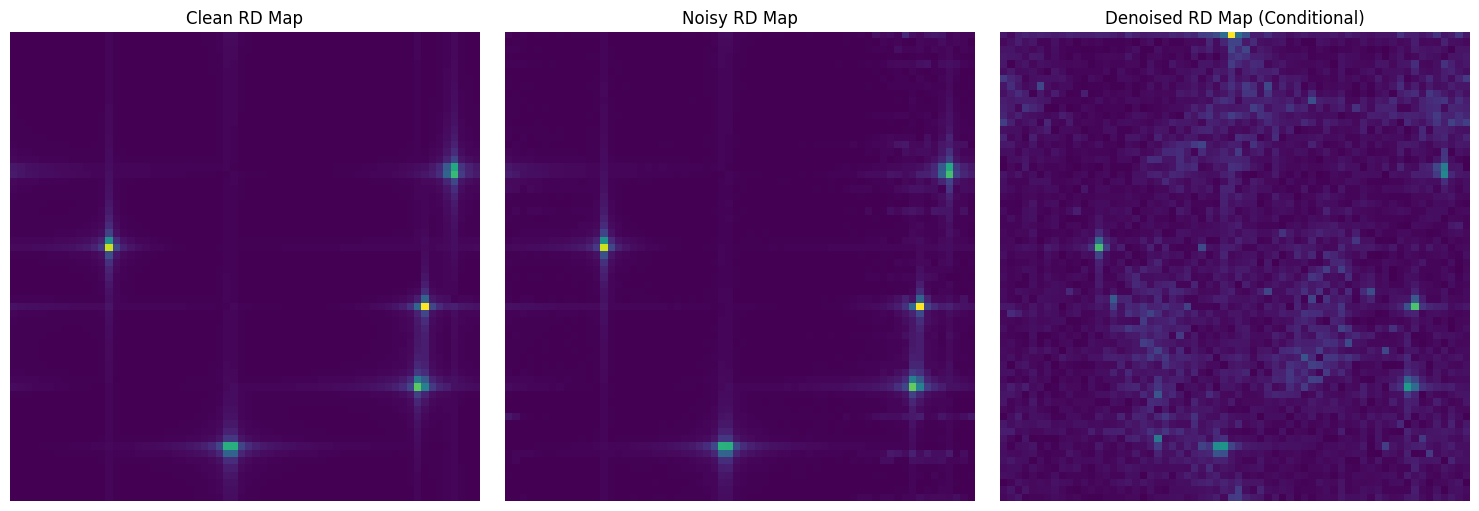

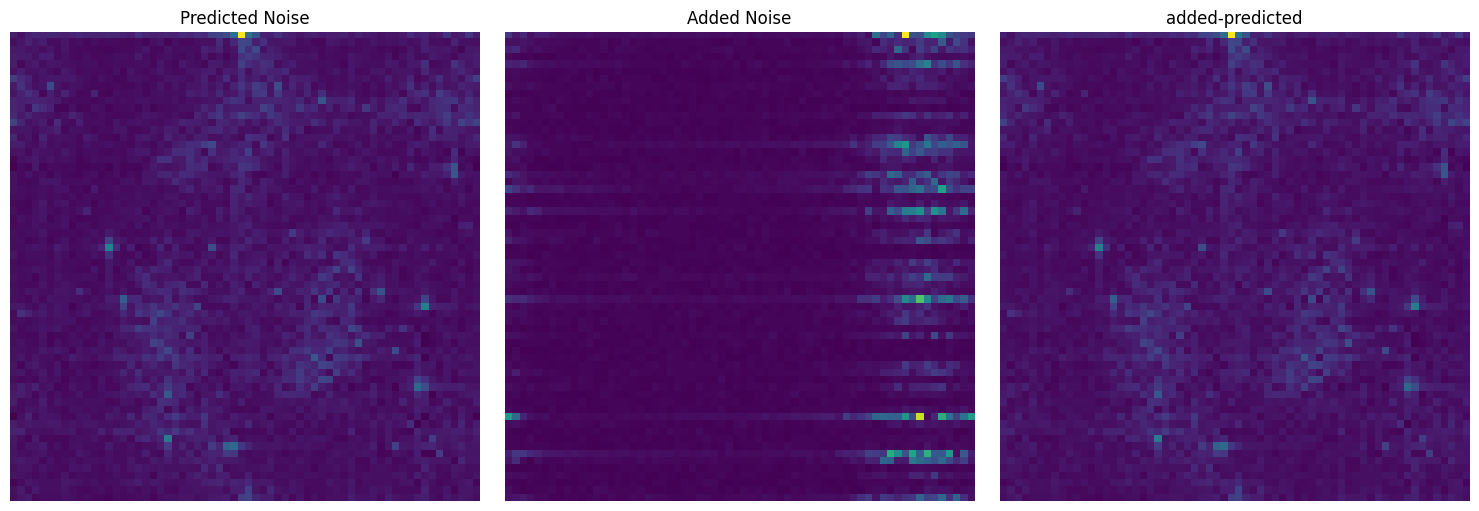

In [19]:
def generate_range_steering_matrix(N=64, dR=64, B=50e6, c=3e8):
    rng_res = c / (2 * B)
    r_vals = torch.arange(dR) * rng_res
    n_vals = torch.arange(N)
    phase = -1j * 2 * torch.pi * (2 * B) / (c * N)
    R = torch.exp(phase * torch.outer(n_vals, r_vals))
    return R

def generate_doppler_steering_matrix(K=64, dV=64, fc=9.39e9, T0=1e-3, c=3e8):
    vel_res = c / (2 * fc * K * T0)
    v_vals = torch.linspace(-dV // 2, dV // 2, dV) * vel_res
    k_vals = torch.arange(K)
    phase = -1j * 2 * torch.pi * (2 * fc * T0) / c
    V = torch.exp(phase * torch.outer(k_vals, v_vals))
    return V

def create_rd_map(IQ_map):
    # Ensure IQ_map is a tensor
    if not torch.is_tensor(IQ_map):
        IQ_map = torch.from_numpy(IQ_map)
    
    # Convert IQ_map to a complex tensor if it's not already
    if not torch.is_complex(IQ_map):
        IQ_map = IQ_map.to(torch.complex64)
    
    # Get the device of the IQ_map
    dev = IQ_map.device
    
    # Generate steering matrices on the same device
    R = generate_range_steering_matrix().to(dev)
    V = generate_doppler_steering_matrix().to(dev)
    
    # Compute the RD map using the Hermitian transpose for R
    RD_map = torch.abs(R.T.conj() @ IQ_map @ V.conj())
    
    # Move the result to CPU for visualization
    RD_map = RD_map.clone().detach().resolve_conj().cpu()
    return RD_map

def run_inference():

    # 1. Instantiate the model with updated channels:
    #    - in_channels=4 (for [signal_real, signal_imag, IQ_real, IQ_imag])
    #    - out_channels=2 (predicting the real and imaginary parts)
    cond_unet = Conditional_UNet().to(device)
    cond_diffusion = ConditionalDiffusion(model=cond_unet, T=1000, beta_start=1e-4, beta_end=0.02).to(device)
    

    # 2. Load the saved best checkpoint
    checkpoint_path = "/home/hawk/Desktop/Heavy Detector/Heavy-Clutter-Detection/notebooks/new_diffusion.pth"
    cond_diffusion.load_state_dict(torch.load(checkpoint_path, map_location=device))
    cond_diffusion.eval()

    # 3. Get a sample from dataset (or use your own custom input)
    #    Here we assume the dataset returns a tuple where:
    #       element 0: clean signal (complex tensor)
    #       element 3: IQ (noisy measurement, complex tensor)
    signal, C, W, IQ, _, _ = RadarDataset(num_samples=100, n_targets=8, random_n_targets=True,snr=30, cnr=15)[0]
    
    # 4. Prepare the condition for the model:
    #    Convert the noisy IQ signal into a 2-channel tensor (real & imag)
    cond_img = torch.cat([IQ.real.unsqueeze(0), IQ.imag.unsqueeze(0)], dim=0)  # (2, H, W)
    cond_img = cond_img.unsqueeze(0).to(device)  # (1, 2, H, W)
    # The desired sample shape for the diffusion model is (1,2,H,W)
    sample_shape = (1, 2, IQ.shape[0], IQ.shape[1])

    # 5. Generate a denoised sample using the diffusion model
    with torch.no_grad():
        generated_sample = cond_diffusion.sample(cond_img, sample_shape)  # (1,2,H,W)

    # 6. Convert the generated 2-channel tensor into a complex tensor
    generated_complex = torch.complex(generated_sample[0,0,:,:], generated_sample[0,1,:,:])
    
    # For visualization, use the original clean signal and IQ as complex images.
    # If they already are complex, no further conversion is needed.
    # (If needed, you can also combine two channels as done for generated_complex.)
    
    # 7. Visualization of RD maps
    fig, axes = plt.subplots(1, 3, figsize=(15,5))
    
    axes[0].imshow(abs(signal), cmap='viridis')
    axes[0].set_title("Clean IQ Map")
    axes[0].axis("off")

    axes[1].imshow(abs(W+C), cmap='viridis')
    axes[1].set_title("Noisy IQ Map")
    axes[1].axis("off")

    axes[2].imshow(abs(IQ-generated_complex.cpu()), cmap='viridis')
    axes[2].set_title("Denoised IQ Map (Conditional)")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(1, 3, figsize=(15,5))
    
    axes[0].imshow(create_rd_map(signal), cmap='viridis')
    axes[0].set_title("Clean RD Map")
    axes[0].axis("off")

    axes[1].imshow(create_rd_map(IQ), cmap='viridis')
    axes[1].set_title("Noisy RD Map")
    axes[1].axis("off")

    axes[2].imshow(create_rd_map(generated_complex), cmap='viridis')
    axes[2].set_title("Denoised RD Map (Conditional)")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(1, 3, figsize=(15,5))
    
    axes[0].imshow(create_rd_map(generated_complex)-create_rd_map(IQ), cmap='viridis')
    axes[0].set_title("Predicted Noise")
    axes[0].axis("off")

    axes[1].imshow(create_rd_map(C)+create_rd_map(W), cmap='viridis')
    axes[1].set_title("Added Noise")
    axes[1].axis("off")

    axes[2].imshow(create_rd_map(C)+create_rd_map(W)-(create_rd_map(IQ)-create_rd_map(generated_complex)), cmap='viridis')
    axes[2].set_title("added-predicted")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

run_inference()


In [76]:
class Diffusion:
    def __init__(self, noise_steps=1000, beta_start=1e-4, beta_end=0.02, img_size=64, c_in=2, c_out=2, device="cuda", **kwargs):
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.beta = self.prepare_noise_schedule().to(device)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)
        self.model = Conditional_UNet(c_in, c_out)
        self.ema_model = copy.deepcopy(self.model).eval().requires_grad_(False)
        self.device = device
        self.c_in = c_in
        self.c_out = c_out

    def prepare_noise_schedule(self):
        return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)
    
    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.noise_steps, size=(n,))
    
    def noise_images(self, x, t):
        "add noise to images at instant t"
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:,None, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1-self.alpha_hat[t])[:, None, None, None]
        epsilon = torch.rand_like(x)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * epsilon, epsilon
    
    def train_step(self, loss):
        self.optimizer.zero_grad()
        self.scaler.scale(loss).backward()
        self.scaler.step(self.optimizer)
        self.scaler.update()
        self.ema.step_ema(self.ema_model, self.model)
        self.scheduler.step()

    def load(self, model_ckpt_path, model_ckpt="ckpt.pt", ema_model_ckpt="ema_ckpt.pt"):
        self.model.load_state_dict(torch.load(os.path.join(model_ckpt_path, model_ckpt)))
        self.ema_model.load_state_dict(torch.load(os.path.join(model_ckpt_path, ema_model_ckpt)))

    def save_model(self, run_name, epoch=-1):
        "save model locally"
        torch.save(self.model.state_dict(), os.path.join("models", run_name, f"ckpt.pt"))
        torch.save(self.ema_model.state_dict(), os.path.join("models", run_name, f"ema_ckpt.pt"))
        torch.save(self.optimizer.state_dict(), os.path.join("models", run_name, f"optim.pt"))

    def prepare(self, args):
        make_folders(args.run_name)
        self.train_dataloader, self.val_dataloader = get_data(args)
        self.optimizer = optim.AdamW(self.model.parameters(), lr=args.lr, eps=1e-5)
        self.scheduler = optim.lr_scheduler.OneCycleLR(self.optimizer, max_lr=args.lr, steps_per_epoch=len(self.train_dataloader), epochs=args.epochs)
        self.mse = nn.MSELoss()
        self.ema = EMA(0.995)
        self.scaler = torch.cuda.amp.GradScaler()

    def fit(self, args):
        for epoch in progress_bar(range(args.epochs), total=args.epochs, leave=True):
            _ = self.one_epoch(train=True)

            if args.do_validation:
                avg_loss = self.one_epoch(train=False)
            
        self.save_model(run_name=args.run_name, epoch=epoch)















    def one_epoch(self, train=True):
        avg_loss = 0.
        if train: self.model.train()
        else: self.model.eval()
        pbar = progress_bar(self.train_dataloader, leave=False)
        for i, (images, nimages) in enumerate(pbar):
            with torch.autocast("cuda") and (torch.inference_mode() if not train else torch.enable_grad()):
                images = images.to(self.device)
                nimages = nimages.to(self.device)
                t = self.sample_timesteps(images.shape[0]).to(self.device)
                x_t, noise = self.noise_images(images, t)
                predicted_noise = self.model(x_t, t, nimages)
                loss = self.mse(noise, predicted_noise)
                avg_loss += loss
            if train:
                self.train_step(loss)
            pbar.comment = f"MSE={loss.item():2.3f}"
        return avg_loss.mean().item()


